# Filtering

Part of this project will rely on finding the relationship between different frequency components within the O2 data and the LFP data. This notebook will perform Fourier transforms and low/high pass filtering on the O2 data to get a better understanding of the data and Julia libraries.

In [3]:
using Plots
using FFTW
using DSP
using Statistics
using StatsBase

## Importing

In [10]:
include("../helpers/importing.jl")
o2 = import_o2("Exp 2/R7/o2 r7.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [328293.0, 450314.0, 495567.0, 535427.0, 627203.0, 731830.0, …
  "sync"       => [30452.0, 40944.0, 51395.0, 61876.0, 72372.0, 82849.0, 93294.…
  "data"       => [-269.721, -269.721, -269.721, -269.721, -269.721, -269.721, …
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  1.5976f…

In [11]:
# Get a subset of the data
o2["data"] = standardize(ZScoreTransform, o2["data"][100:10000])
o2["timestamps"] = o2["timestamps"][100:10000]

9901-element Vector{Float32}:
   99.0
  100.0
  101.0
  102.0
  103.0
  104.0
  105.0
  106.0
  107.0
  108.0
  109.0
  110.0
  111.0
    ⋮
 9988.0
 9989.0
 9990.0
 9991.0
 9992.0
 9993.0
 9994.0
 9995.0
 9996.0
 9997.0
 9998.0
 9999.0

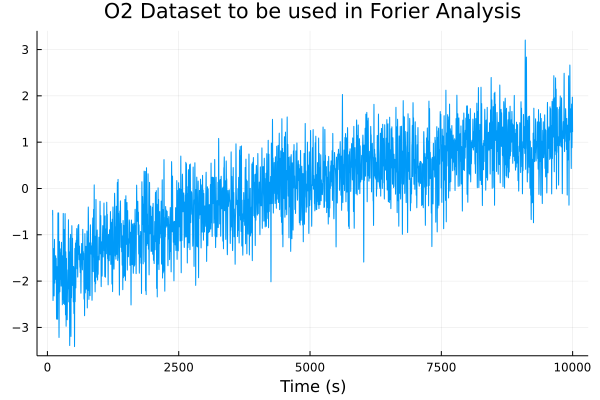

In [12]:
plot(o2["timestamps"], o2["data"], legend=false)
title!("O2 Dataset to be used in Forier Analysis")
xlabel!("Time (s)")

## Fourier Transform

This section will attempt to compute and graph the Fourier Space of the data to get a better understanding of the frequency components that it comprises.

In [14]:
sampling_rate = 1000

F = fft(o2["data"])
freqs = fftfreq(length(o2["timestamps"]), sampling_rate)

9901-element Frequencies:
  0.0
  0.100999899000101
  0.201999798000202
  0.30299969700030305
  0.403999596000404
  0.504999495000505
  0.6059993940006061
  0.7069992930007071
  0.807999192000808
  0.908999091000909
  1.00999899000101
  1.110998889001111
  1.2119987880012122
  ⋮
 -1.2119987880012122
 -1.110998889001111
 -1.00999899000101
 -0.908999091000909
 -0.807999192000808
 -0.7069992930007071
 -0.6059993940006061
 -0.504999495000505
 -0.403999596000404
 -0.30299969700030305
 -0.201999798000202
 -0.100999899000101

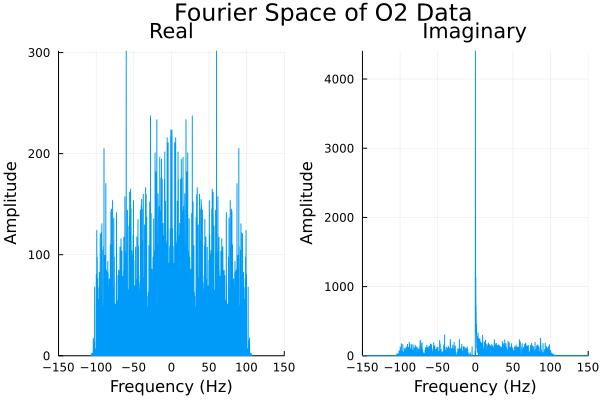

In [15]:
# Plot
re = plot(freqs, real(F), title = "Real", xlim=(-150,150), ylim=(0,maximum(real(F))), legend=false)
im = plot(freqs, imag(F), title = "Imaginary", xlim=(-150,150), ylim=(0,maximum(imag(F))), legend=false)
plot(re,im, layout=layout = grid(1, 2), plot_title="Fourier Space of O2 Data")
xlabel!("Frequency (Hz)")
ylabel!("Amplitude")

## Ideal Filters

### Low Pass Filtering

Objective: extract the low frequency signals from the o2 data (<1Hz).

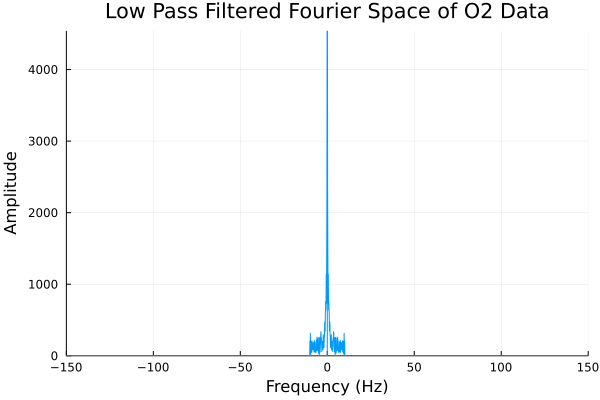

In [16]:
pass_freq = 10

low_pass_F = copy(F)
low_pass_F[findall(x->x>pass_freq, freqs)] .= 0
low_pass_F[findall(x->x<-pass_freq, freqs)] .= 0
plot(freqs, abs.(low_pass_F), xlim=(-150,150), ylim=(0,maximum(abs.(low_pass_F))), legend=false)
title!("Low Pass Filtered Fourier Space of O2 Data")
xlabel!("Frequency (Hz)")
ylabel!("Amplitude")

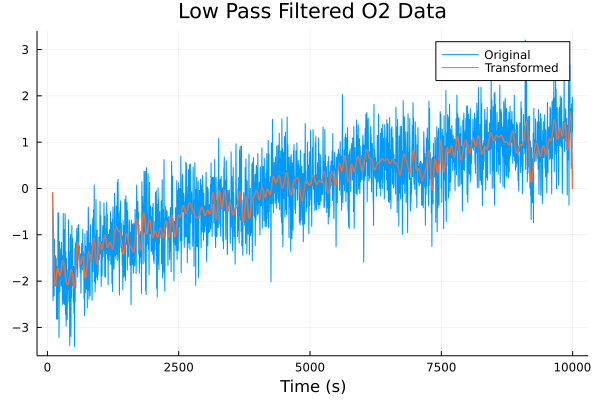

In [18]:
plot(o2["timestamps"], o2["data"], label="Original")
plot!(o2["timestamps"], real(ifft(low_pass_F)), label="Transformed", linewidth = 1.5)
title!("Low Pass Filtered O2 Data")
xlabel!("Time (s)")

### High Pass Filtering

Objective: extract the high frequency signals from the o2 data (>1Hz).

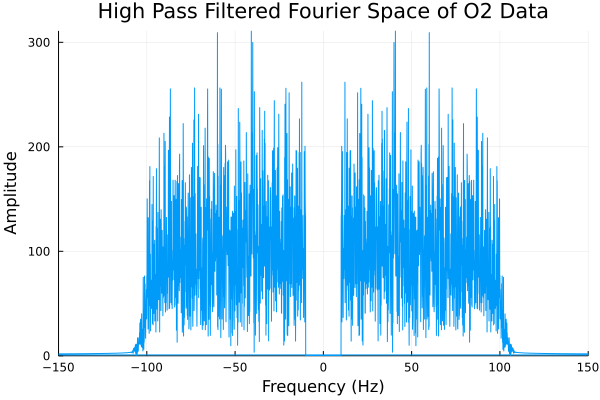

In [19]:
pass_freq = 10

high_pass_F = copy(F)
high_pass_F[findall(x->-pass_freq<x<pass_freq, freqs)] .= 0
plot(freqs, abs.(high_pass_F), xlim=(-150,150), ylim=(0,maximum(abs.(high_pass_F))), legend=false)
title!("High Pass Filtered Fourier Space of O2 Data")
xlabel!("Frequency (Hz)")
ylabel!("Amplitude")

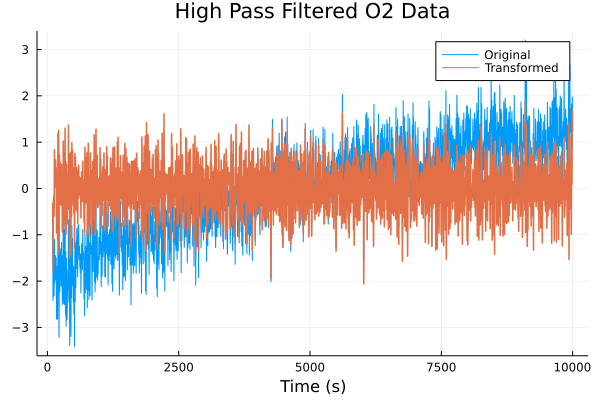

In [20]:
plot(o2["timestamps"], o2["data"], label="Original")
plot!(o2["timestamps"], real(ifft(high_pass_F)), label="Transformed", linewidth = 1.5)
title!("High Pass Filtered O2 Data")
xlabel!("Time (s)")

## Butterworth's Filters

### Low Pass Filtering

$$H(u) = \frac{1}{1+(r(u)/r_0)^{2n}},\ of\ order\ n,\ where\ r(u)=|freq(u)|$$

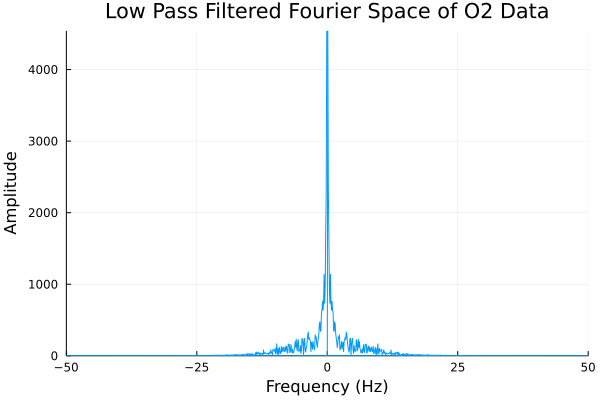

In [21]:
pass_freq = 10
function butterworth_low(freq, pass_freq, n)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

b_low_pass_F = copy(F)
for i in 1:length(b_low_pass_F)
    b_low_pass_F[i] *= butterworth_low(freqs[i], pass_freq, 2)
end

plot(freqs, abs.(b_low_pass_F), xlim=(-50,50), ylim=(0,maximum(abs.(low_pass_F))), legend=false)
title!("Low Pass Filtered Fourier Space of O2 Data")
xlabel!("Frequency (Hz)")
ylabel!("Amplitude")

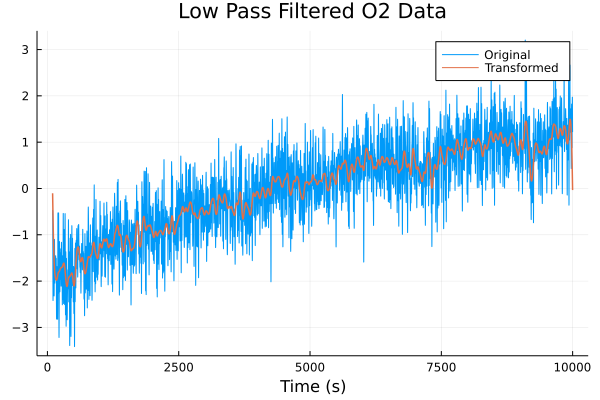

In [22]:
plot(o2["timestamps"], o2["data"], label="Original")
plot!(o2["timestamps"], real(ifft(b_low_pass_F)), label="Transformed", linewidth = 1.5)
title!("Low Pass Filtered O2 Data")
xlabel!("Time (s)")

### High Pass Filtering

$$H(u) = \frac{1}{1+(r_0/r(u))^{2n}},\ of\ order\ n,\ where\ r(u)=|freq(u)|$$

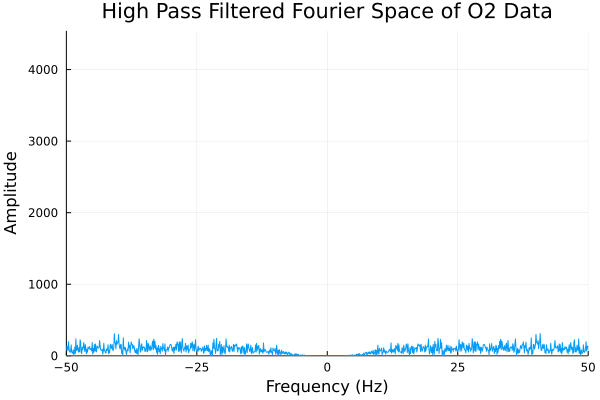

In [23]:
pass_freq = 10
function butterworth_high(freq, pass_freq, n)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end

b_high_pass_F = copy(F)
for i in 1:length(b_high_pass_F)
    b_high_pass_F[i] *= butterworth_high(freqs[i], pass_freq, 2)
end

plot(freqs, abs.(b_high_pass_F), xlim=(-50,50), ylim=(0,maximum(abs.(low_pass_F))), legend=false)
title!("High Pass Filtered Fourier Space of O2 Data")
xlabel!("Frequency (Hz)")
ylabel!("Amplitude")

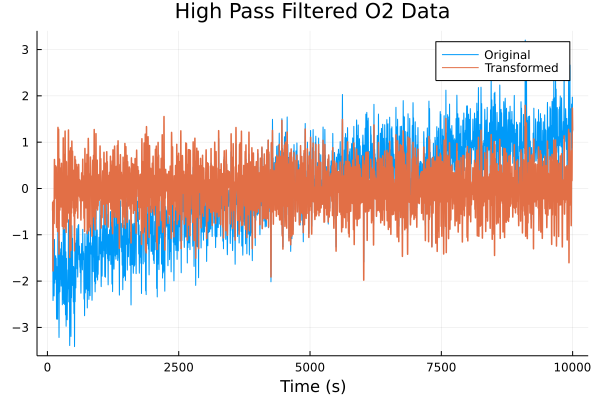

In [25]:
plot(o2["timestamps"], o2["data"], label="Original")
plot!(o2["timestamps"], real(ifft(b_high_pass_F)), label="Transformed", linewidth = 1.5)
title!("High Pass Filtered O2 Data")
xlabel!("Time (s)")

## Band-Pass Butterworth Filtering

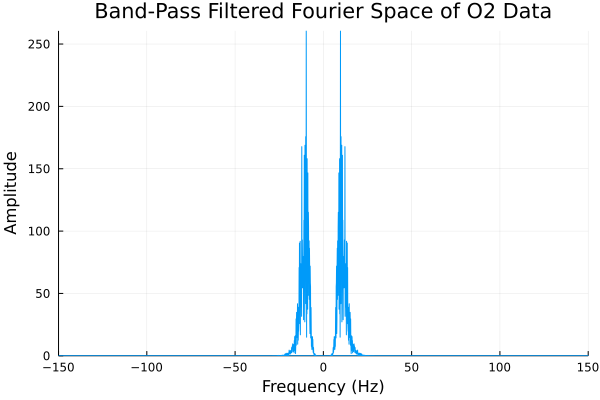

In [30]:
b_band_pass_F = copy(F)
for i in 1:length(b_band_pass_F)
    b_band_pass_F[i] = b_band_pass_F[i] * butterworth_low(freqs[i], 13, 5) * butterworth_high(freqs[i], 8, 5)
end

plot(freqs, abs.(b_band_pass_F), xlim=(-150,150), ylim=(0,maximum(abs.(b_band_pass_F))), legend=false)
title!("Band-Pass Filtered Fourier Space of O2 Data")
xlabel!("Frequency (Hz)")
ylabel!("Amplitude")

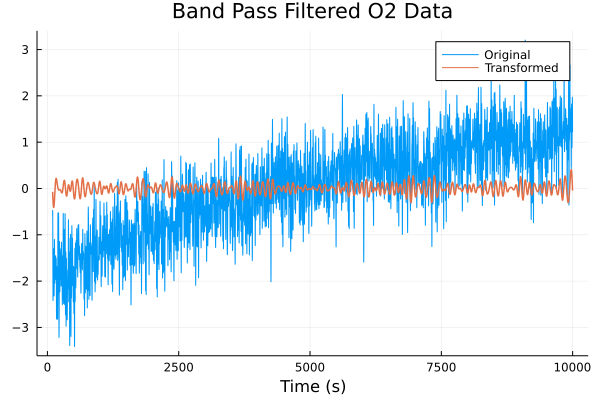

In [31]:
plot(o2["timestamps"], o2["data"], label="Original")
plot!(o2["timestamps"], real(ifft(b_band_pass_F)), label="Transformed", linewidth = 1.5)
title!("Band Pass Filtered O2 Data")
xlabel!("Time (s)")

## Spectrogram

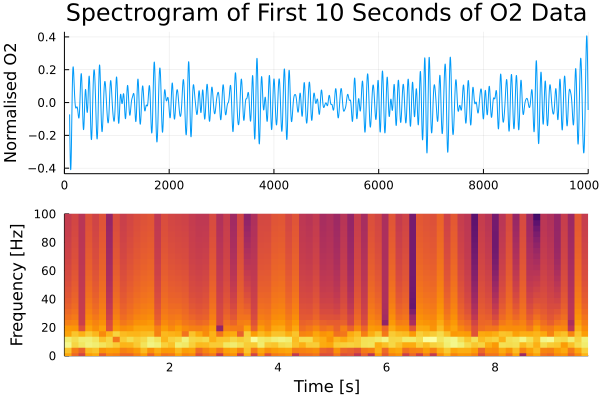

In [38]:
spec = spectrogram(real(ifft(b_band_pass_F)), 255, 128, fs=1000)
ht = heatmap(spec.time, spec.freq, pow2db.(spec.power), xguide="Time [s]", yguide="Frequency [Hz]", ylim=(0,100), legend = false)
data = plot(o2["timestamps"], real(ifft(b_band_pass_F)), size = (500, 500), xlim=(0,10000), yguide="Normalised O2", legend = false)
plot(data, ht, layout = grid(2, 1), plot_title="Spectrogram of First 10 Seconds of O2 Data")